In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from skimage.draw import polygon
import matplotlib.pyplot as plt
import datetime

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from urllib import parse
from detectron2.projects import point_rend
from torchvision.transforms import Normalize, ToTensor
from detectron2.data import DatasetMapper, build_detection_train_loader

In [2]:
annot_file = "E:\\moseq_raw_data\\unet_testing\\mask_keypoints_for_michael\\result.json" #"C:\\Users\\Josh\\Downloads\\2021-03-25-13-57-07-JSON\\result.json" #"C:\\Users\\Josh\\Downloads\\2021-03-24-17-08-35-JSON\\result.json" #"C:\\Users\\Josh\\Downloads\\2021-03-15-11-13-10-JSON\\result.json"
def get_dataset_statistics(dset):
    ''' Calculate mean a standard deviation of images over a dataset.
    
    online mean and stdev calculation: https://stackoverflow.com/a/15638726
    '''
    # online mean and stdev calculation
    # https://stackoverflow.com/a/15638726
    
    _count = 0
    _mean = 0
    _m2 = 0
    
    for d in dset:
        im = cv2.imread(d["file_name"])[:, :, 0]
        for x in im.ravel():
            _count += 1
            delta = x - _mean
            _mean += delta / _count
            _m2 += delta * (x - _mean)
    
    _variance = _m2 / (_count - 1)
    _stdev = np.sqrt(_variance)
    
    return (_mean, _stdev)

def get_dataset_im_size_range(dset):
    ''' Calculate min/max image width and height
    
    Returns: ((min_width, max_width), (min_height, max_height))
    '''
    widths = [d['width'] for d in dset]
    heights = [d['height'] for d in dset]
    return (
        (np.min(widths), np.max(widths)),
        (np.min(heights), np.max(heights))
    )

def get_dataset_bbox_range(dset):
    ''' Calculates bounding box min/mean/max with and height
    '''
    widths = []
    heights = []
    for d in dset:
        box = d['annotations'][0]['bbox']
        widths.append(box[2] - box[0])
        heights.append(box[3] - box[1])
    print("Width: {:.2f}/{:.2f}/{:.2f}".format(np.min(widths), np.mean(widths), np.max(widths)))
    print("Height: {:.2f}/{:.2f}/{:.2f}".format(np.min(heights), np.mean(heights), np.max(heights)))

keypoint_names = [
    'Nose',
    'Left Ear',
    'Right Ear',
    'Neck',
    'Left Hip',
    'Right Hip',
    'TailBase',
    'TailTip'
]

def read_annotations():
    with open(annot_file, 'r') as fp:
        data = json.load(fp)

        completions = []
        for entry in data:
            annot = {}
            kpts = {}
            
            polyfound = False
            
            for rslt in entry['completions'][0]['result']:
                
                if rslt['type'] == 'polygonlabels':
                    poly = np.array(rslt['value']['points'])
                    poly[:,1] = (poly[:,1] * rslt['original_width']) / 100
                    poly[:,0] = (poly[:,0] * rslt['original_height']) / 100
                    seg = np.empty((poly.size,), dtype=poly.dtype)
                    seg[0::2] = poly[:,0]
                    seg[1::2] = poly[:,1]
                    
                    annot['bbox'] = [
                        np.min(poly[:,0]),
                        np.min(poly[:,1]),
                        np.max(poly[:,0]),
                        np.max(poly[:,1]),
                    ]
                    annot['bbox_mode'] = BoxMode.XYXY_ABS
                    annot['category_id'] = 0
                    annot['segmentation'] = [list(seg)]
                    polyfound = True
                    
                elif rslt['type'] == 'keypointlabels':
                    if 'points' in rslt['value']:
                        #print('Skipping unexpected points in keypoint', rslt)
                        continue
                    try:
                        kpts[rslt['value']['keypointlabels'][0]] = {
                            'x': (rslt['value']['x'] * rslt['original_width']) / 100,
                            'y': (rslt['value']['y'] * rslt['original_height']) / 100,
                            'v': 2
                        }
                    except:
                        print(rslt['value'])
                        raise
            
            annot_keypoints = []
            for kp in keypoint_names:
                if kp in kpts:
                    k = kpts[kp]
                    annot_keypoints.extend([k['x'], k['y'], k['v']])
                else:
                    #print('missing keypoint {} in {}'.format(kp, entry['id']))
                    annot_keypoints.extend([0, 0, 0])
            annot['keypoints'] = annot_keypoints
            
            tsk_path = ''
            if 'task_path' in entry:
                tsk_path = entry['task_path']
            else:
                tsk_path = entry['data']['image']
                #o = parse.urlparse(entry['data']['image'])
                #q = parse.parse_qs(o.query)
                #tsk_path = os.path.join(q['d'][0], os.path.basename(o.path))
                
                
            if not polyfound:
                print('poly not found!')
                
            completions.append({
                'file_name': tsk_path,
                'width': rslt['original_width'],
                'height': rslt['original_height'],
                'image_id': entry['id'],
                'annotations': [annot]
            })
        
        return completions
dataset_dicts = read_annotations()
print("Num Items: ", len(dataset_dicts))
#print(get_dataset_statistics(dataset_dicts)) # ---->> (1.8649656981366263, 6.441470388478531)
print("Image size range: ", get_dataset_im_size_range(dataset_dicts))
np.min(get_dataset_im_size_range(dataset_dicts))
get_dataset_bbox_range(dataset_dicts)

Num Items:  472
Image size range:  ((244, 250), (240, 250))
Width: 14.88/50.50/92.82
Height: 14.88/54.78/92.33


In [3]:
DatasetCatalog.register("moseq", read_annotations)
MetadataCatalog.get("moseq").thing_classes = ["mouse"]
MetadataCatalog.get("moseq").thing_colors = [(0, 0, 255)]
MetadataCatalog.get("moseq").keypoint_names = keypoint_names
MetadataCatalog.get("moseq").keypoint_flip_map = [] #[('Left Ear', 'Right Ear'), ('Left Hip', 'Right Hip')]
MetadataCatalog.get("moseq").keypoint_connection_rules = [
    ('Nose', 'Left Ear', (166, 206, 227)),
    ('Nose', 'Right Ear', (31,  120, 180)),
    ('Neck', 'Left Ear', (166, 206, 227)),
    ('Neck', 'Right Ear', (31,  120, 180)),
    ('Neck', 'Left Hip', (178, 223, 138)),
    ('Neck', 'Right Hip', (51,  160, 44 )),
    ('TailBase', 'Left Hip', (178, 223, 138)),
    ('TailBase', 'Right Hip', (51,  160, 44 )),
    ('TailBase', 'TailTip', (251, 154, 153)),
]


dataset_metadata = MetadataCatalog.get("moseq")

c:\users\josh\anaconda3\envs\moseq-detectron2\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


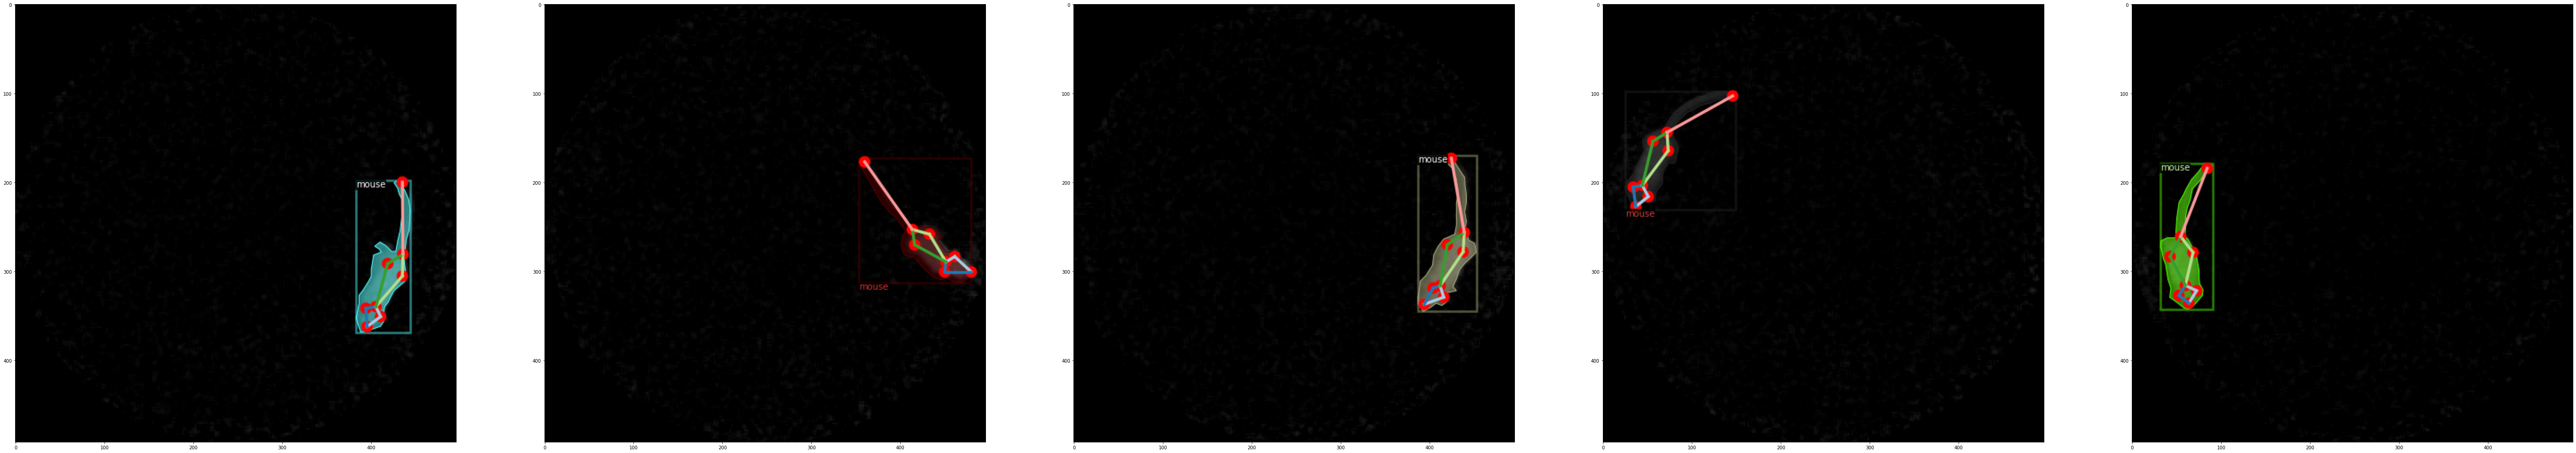

In [4]:
num = 5
fig, axs = plt.subplots(1, num, figsize=(20*num,20))
for d, ax in zip(random.sample(dataset_dicts, num), axs):
    im = cv2.imread(d["file_name"])
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata, 
                   scale=2, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    ax.imshow(out.get_image())
fig.show()

In [5]:
cfg = get_cfg()


# USE POINTREND
#point_rend.add_pointrend_config(cfg)
#cfg.merge_from_file("detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")

# USE Keypoint RCNN
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

# USE MASK RCNN
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.MASK_ON = True
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = len(keypoint_names)
cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA = 0.5
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 1500

#cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8], [16], [32], [64], [128]]


cfg.DATASETS.TRAIN = ("moseq",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.INPUT.MIN_SIZE_TRAIN = (240,)
cfg.INPUT.MAX_SIZE_TRAIN = 250
cfg.INPUT.MIN_SIZE_TEST = 240
cfg.INPUT.MAX_SIZE_TEST = 250
cfg.INPUT.RANDOM_FLIP = "none"

#px_mean, px_stdev = get_dataset_statistics(dataset_dicts)
#cfg.MODEL.PIXEL_MEAN = [1.865, 1.865, 1.865]
#cfg.MODEL.PIXEL_STD = [6.441, 6.441, 6.441]


cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.SOLVER.MAX_ITER = 250000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = (50000, 100000, 200000)        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)


cfg.OUTPUT_DIR = './output_6'
cfg.VIS_PERIOD = 100
#cfg.MODEL.WEIGHTS = None

cfg.TEST.DETECTIONS_PER_IMAGE = 1

print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ('moseq',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 250
  MAX_SIZE_TRAIN: 250
  MIN_SIZE_TEST: 240
  MIN_SIZE_TRAIN: (240,)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: none
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 'res4', 'res5']
    NORM: 
    OUT_CHANNELS: 256
 

In [6]:
cfg.OUTPUT_DIR = os.path.join(cfg.OUTPUT_DIR, datetime.datetime.now().strftime("%Y-%m-%dT%H-%M_%S"))
print("Model output: {}".format(cfg.OUTPUT_DIR))
os.makedirs(cfg.OUTPUT_DIR, exist_ok=False)
with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), 'w') as f:
    f.write(cfg.dump())
#turn off augmentations
#DefaultTrainer.build_train_loader = lambda cls, cfg: build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations=[]))
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

Model output: ./output_6\2021-06-11T17-51_51
[06/11 17:51:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_feature

Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 8, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.


[06/11 17:51:53 d2.engine.train_loop]: Starting training from iteration 0
[06/11 17:52:05 d2.utils.events]:  eta: 23:18:59  iter: 19  total_loss: 9.072  loss_cls: 0.07886  loss_box_reg: 0.01357  loss_mask: 0.6853  loss_keypoint: 8.074  loss_rpn_cls: 0.2017  loss_rpn_loc: 0.009176  time: 0.3404  data_time: 0.1631  lr: 4.9952e-05  max_mem: 1857M
[06/11 17:52:12 d2.utils.events]:  eta: 23:34:22  iter: 39  total_loss: 9.017  loss_cls: 0.07602  loss_box_reg: 0.01738  loss_mask: 0.6459  loss_keypoint: 8.073  loss_rpn_cls: 0.1539  loss_rpn_loc: 0.009941  time: 0.3438  data_time: 0.0047  lr: 9.9902e-05  max_mem: 2004M
[06/11 17:52:19 d2.utils.events]:  eta: 23:46:16  iter: 59  total_loss: 8.902  loss_cls: 0.06841  loss_box_reg: 0.02503  loss_mask: 0.6214  loss_keypoint: 8.048  loss_rpn_cls: 0.1096  loss_rpn_loc: 0.01045  time: 0.3524  data_time: 0.0032  lr: 0.00014985  max_mem: 2433M
[06/11 17:52:27 d2.utils.events]:  eta: 1 day, 0:31:58  iter: 79  total_loss: 8.784  loss_cls: 0.06995  loss_bo

KeyboardInterrupt: 

In [15]:
cfg.OUTPUT_DIR = './output_6/2021-06-11T17-51_51/'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,  'model_0127999.pth') #"model_final.pth")  # path to the model we just trained     "model_0001999.pth")#
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set a custom testing threshold
cfg.TEST.DETECTIONS_PER_IMAGE = 1
predictor = DefaultPredictor(cfg)

In [8]:
dataset_metadata = MetadataCatalog.get("moseq")
dataset_dicts = read_annotations()

c:\users\josh\anaconda3\envs\moseq-detectron2\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


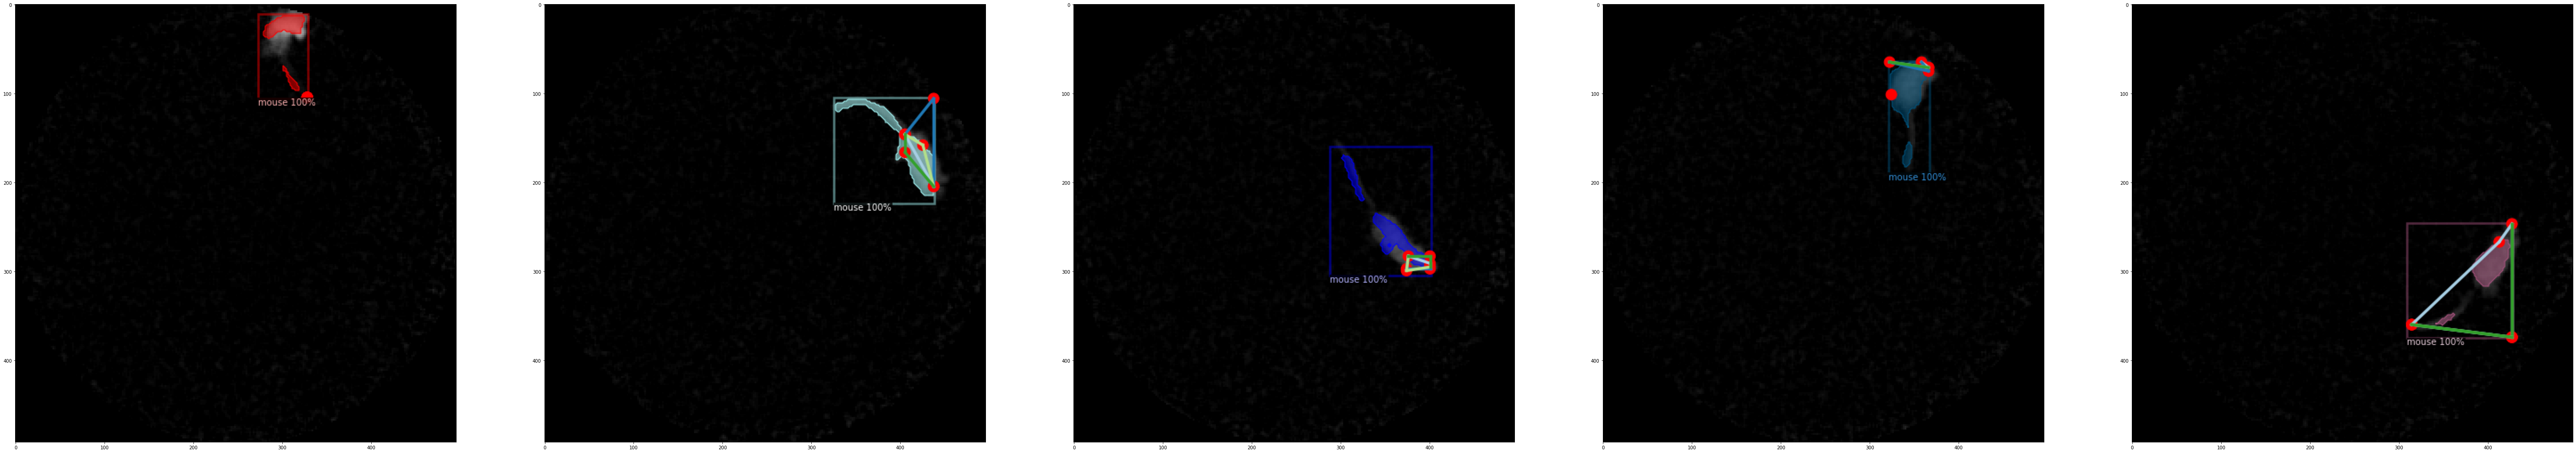

In [24]:
num = 5
#to_tensor = ToTensor()
#norm = Normalize(cfg.MODEL.PIXEL_MEAN, cfg.MODEL.PIXEL_STD)
fig, axs = plt.subplots(1, num, figsize=(20*num,20))
for d, ax in zip(random.sample(dataset_dicts, num), axs):
    im = cv2.imread(d["file_name"])
    #im = (im - (cfg.MODEL.PIXEL_MEAN[0] * 255)) / (cfg.MODEL.PIXEL_STD[0] * 255)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata, 
                   scale=2.0, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    #out = v.draw_dataset_dict(d)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    ax.imshow(out.get_image())
fig.show()

ValueError: step must be greater than zero

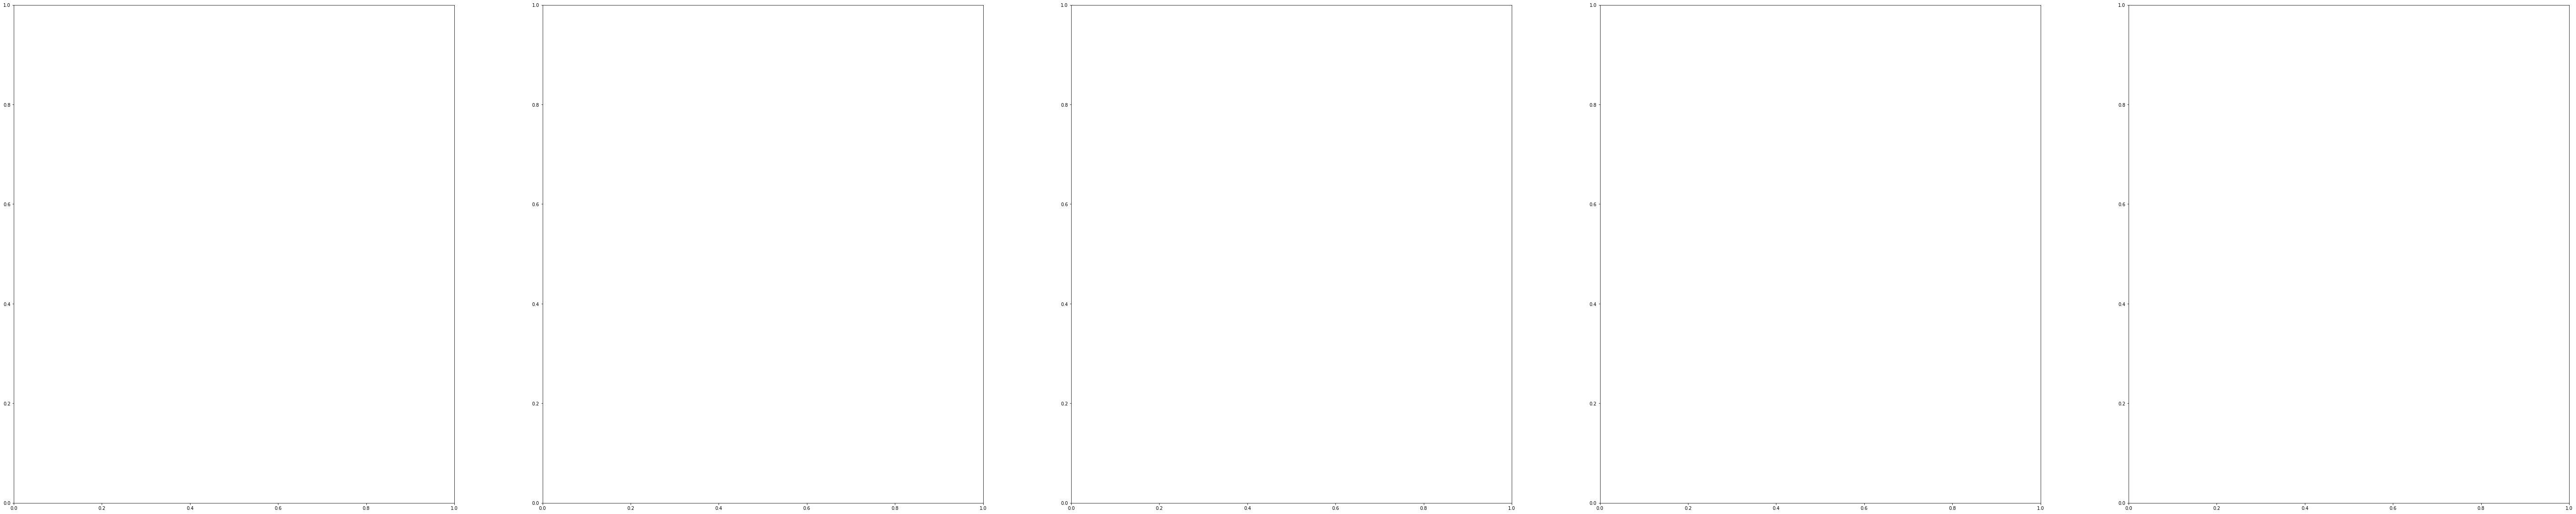

In [21]:
from detectron2.modeling import build_model
import torch

model = build_model(cfg)  # returns a torch.nn.Module

from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)  # load a file, usually from cfg.MODEL.WEIGHTS

model.eval()
with torch.no_grad():
    num = 5
    #to_tensor = ToTensor()
    #norm = Normalize(cfg.MODEL.PIXEL_MEAN, cfg.MODEL.PIXEL_STD)
    fig, axs = plt.subplots(1, num, figsize=(20*num,20))
    for d, ax in zip(random.sample(dataset_dicts, num), axs):
        im = cv2.imread(d["file_name"])
        im = torch.as_tensor(im.transpose(2, 0, 1))
        inputs = [{'image': im}]
        #im = (im - (cfg.MODEL.PIXEL_MEAN[0] * 255)) / (cfg.MODEL.PIXEL_STD[0] * 255)
        outputs = model(inputs)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        v = Visualizer(im[:, :, ::-1],
                       metadata=dataset_metadata, 
                       scale=2.0, 
                       instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        #out = v.draw_dataset_dict(d)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        ax.imshow(out.get_image())
fig.show()


In [11]:
for i, d in enumerate(dataset_dicts):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    if len(outputs["instances"]) == 0:
        print(i)

In [12]:
outputs

{'instances': Instances(num_instances=1, image_height=246, image_width=248, fields=[pred_boxes: Boxes(tensor([[176.7684,  45.3847, 211.8927, 115.5817]], device='cuda:0')), scores: tensor([0.9981], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]], device='cuda:0')])}

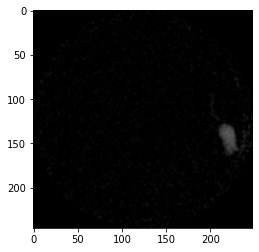

In [17]:
plt.imshow(im)

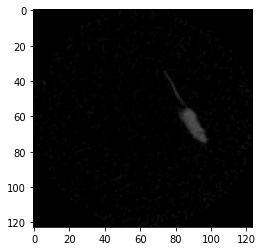

In [11]:
v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())

In [9]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ('moseq',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 'res4', 'res5']
  

In [20]:
get_dataset_statistics(read_annotations())

c:\users\josh\anaconda3\envs\moseq-detectron2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ulong_scalars
  # This is added back by InteractiveShellApp.init_path()


(1.9623623046021288, 189.90349195863183)

In [27]:
DatasetCatalog.get("moseq")

[{'file_name': 'E:\\moseq_raw_data\\unet_testing\\label_studio\\images\\1056.png',
  'width': 248,
  'height': 246,
  'image_id': 1000,
  'annotations': [{'bbox': [17.712, 58.0, 72.816, 131.0],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'segmentation': [[36.08,
      85.6666666666667,
      30.831999999999997,
      88.66666666666666,
      26.24,
      91.0,
      23.616,
      95.6666666666667,
      23.616,
      100.0,
      20.336000000000002,
      105.66666666666669,
      19.024,
      113.0,
      17.712,
      118.66666666666669,
      18.368,
      124.66666666666666,
      19.68,
      131.0,
      25.584,
      129.33333333333331,
      33.455999999999996,
      124.66666666666666,
      32.8,
      120.33333333333334,
      34.112,
      117.66666666666666,
      36.408,
      114.33333333333334,
      37.72,
      110.33333333333334,
      38.376,
      107.00000000000001,
      40.343999999999994,
      103.33333333333331,
      42.96799999999998,

(array([5.8656e+04, 1.4050e+03, 2.3400e+02, 1.3700e+02, 1.3100e+02,
        8.7000e+01, 1.1400e+02, 1.0200e+02, 1.1200e+02, 3.0000e+01]),
 array([ 0. ,  8.4, 16.8, 25.2, 33.6, 42. , 50.4, 58.8, 67.2, 75.6, 84. ]),
 <BarContainer object of 10 artists>)

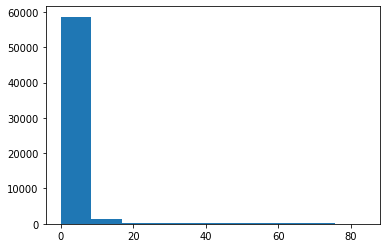

In [12]:
plt.hist(cv2.imread(dataset_dicts[0]["file_name"])[:, :, 0].ravel())

In [10]:
datetime.datetime.now().strftime("%Y-%m-%dT%H-%M_%S")

'2021-04-06T18-38_41'

In [6]:
cfg.OUTPUT_DIR

'./output_6'